In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as plx
import airbnb
import requests
import re
import os
from dotenv import load_dotenv
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
import folium
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import gzip
import shutil

In [2]:

url = "http://data.insideairbnb.com/spain/catalonia/barcelona/2022-12-11/data/listings.csv.gz"

response = requests.get(url)
with open("listings.csv.gz", "wb") as f:
    f.write(response.content)

with gzip.open("listings.csv.gz", "rb") as f_in:
    with open("listings2.csv", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
df = pd.read_csv("listings2.csv")

In [4]:


url2 = "http://data.insideairbnb.com/spain/catalonia/barcelona/2022-12-11/data/reviews.csv.gz"

response2 = requests.get(url2)
with open("reviews.csv.gz", "wb") as g:
    g.write(response2.content)

with gzip.open("reviews.csv.gz", "rb") as g_in:
    with open("reviews2.csv", "wb") as g_out:
        shutil.copyfileobj(g_in, g_out)

In [5]:
df_reviews = pd.read_csv("reviews2.csv")

In [6]:

df2 = df.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', "picture_url", "host_thumbnail_url", "host_picture_url", "host_verifications", "calendar_updated", "calendar_last_scraped"], axis=1)


In [7]:

df_reviews['comments'] = df_reviews['comments'].astype(str)
df_reviews_grouped = df_reviews[['listing_id', 'date', 'comments']].groupby('listing_id').agg({'date': 'first', 'comments': ' '.join})


In [8]:
df3 = df2.merge(df_reviews_grouped, left_on='id', right_index=True)
df3['price_clean'] = [x.strip('$') for x in df3['price']]
df3["price_clean"]=df3["price_clean"].str.replace(',','')
df3["price_clean"].astype(float)
df3['price_clean'] = pd.to_numeric(df3['price_clean'], errors='coerce')
df3['price_clean'] = df3['price_clean'].round().astype(int)
df3 = df3[df3["price_clean"] < 20000]


In [9]:
df3.dropna(subset=['beds'], inplace=True)
df3['beds_clean'] = pd.to_numeric(df3['beds'], errors='coerce')
df3['beds_clean'] = df3['beds_clean'].round().astype(int)


In [36]:
df3_pivot = pd.pivot_table(df3, index="neighbourhood_cleansed", values="price_clean", aggfunc='mean')
df3_pivot.rename(columns={'price_clean':'price average'}, inplace=True)
df3_pivot.reset_index(inplace=True)
df3_pivot.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)


In [16]:
df3_pivot_district = pd.pivot_table(df3, index='neighbourhood_group_cleansed', values=['id', 'beds_clean'], aggfunc={'id':'count', 'beds_clean':'sum'})
df3_pivot_district.rename(columns={'id':'total_airbnbs'}, inplace=True)
df3_pivot_district.sort_values(by='total_airbnbs', ascending=False, inplace=True)
df3_pivot_district.reset_index(inplace=True)

df3_pivot_district.rename(columns={'neighbourhood_group_cleansed':'district'}, inplace=True)


In [38]:
df3_pivot2 = df3.pivot_table(index='neighbourhood_cleansed', values=['id', 'beds_clean', 'price_clean'], aggfunc={'id':'count', 'beds_clean':'sum', 'price_clean':'mean'})
df3_pivot2.reset_index(inplace=True)
df3_pivot2.rename(columns={'neighbourhood_cleansed':'neighbourhood', 'price_clean':'price average', 'id':'total locations', 'beds_clean':'total beds'}, inplace=True)
df3_pivot2.sort_values(by='total locations', ascending=False, inplace=True)
df3_pivot2['price average'] = df3_pivot['price average'].astype(int)


In [39]:
max_idx_price = df3_pivot['price average'].idxmax()
max_ngbhd = df3_pivot.at[max_idx_price, 'neighbourhood']
max_avg_price = df3_pivot.at[max_idx_price, 'price average']
min_idx_price = df3_pivot['price average'].idxmin()
min_ngbhd = df3_pivot.at[min_idx_price, 'neighbourhood']
min_avg_price = df3_pivot.at[min_idx_price, 'price average']


In [40]:
df3_pivot_district = pd.pivot_table(df3, index='neighbourhood_group_cleansed', values=['id', 'beds_clean'], aggfunc={'id':'count', 'beds_clean':'sum'})
df3_pivot_district.rename(columns={'id':'total_airbnbs'}, inplace=True)
df3_pivot_district.sort_values(by='total_airbnbs', ascending=False, inplace=True)
df3_pivot_district.reset_index(inplace=True)
df3_pivot_district.rename(columns={'neighbourhood_group_cleansed':'district'}, inplace=True)


In [41]:
df3_distribution = df3.pivot_table(index='neighbourhood_group_cleansed', values='id', aggfunc='count')
df3_distribution.reset_index(inplace=True)
df3_distribution.rename(columns={'neighbourhood_group_cleansed':'district', 'id':'accommodations'}, inplace=True)
df3_distribution.sort_values(by='accommodations', ascending=True, inplace=True)
df3_distribution['accommodations'] = df3_distribution['accommodations'].astype(int)


In [42]:
price_mean = df3['price_clean'].mean()
price_median = df3['price_clean'].median()
price_mode = df3['price_clean'].mode().values[0]
price_max = df3['price_clean'].max()
price_min = df3['price_clean'].min()
price_std = df3['price_clean'].std()
df3_eda = pd.DataFrame({'price_mean': [price_mean], 'price_median': [price_median], 'price_mode': [price_mode], 'price_max': [price_max], 'price_min': [price_min], 'price_std': [price_std]})


In [53]:

fig1 = px.bar(df3_pivot, x='price average', y='neighbourhood', color='price average', 
    color_continuous_scale=['#FDEB6C', '#FC9885', '#FA6821', '#D94C2A', '#E75554', '#74211C'],
    title='Average Price per Night, by Neighbourhood',
    labels={'price average':'Price Average (€)', 'neighbourhood':'Neighbourhood'},
    text='price average',
    height=1200)

fig1.update_layout(plot_bgcolor='#e6e1cf', xaxis_title='Price Average', yaxis_title='Neighbourhood',
xaxis_tickfont=dict(color='#894329'), yaxis_tickfont=dict(color='#894329'), title_font=dict(color='#894329'),
legend=dict(title_font=dict(color='#894329')))

fig1.show()

In [44]:
url_viajeros_pernocte = "https://servicios.ine.es/wstempus/js/ES/DATOS_TABLA/53822"
response_viajeros_pernocte = requests.request("GET", url_viajeros_pernocte)
viajeros_pernocte = response_viajeros_pernocte.json()


In [45]:
def INE_tables_qty(json):
    bcn_list = []
    num_list = []
    for i in json:
        for key1, val1 in i.items():
            if "Cataluña: Barcelona" in val1:
                bcn_list.append(val1)
        for key2, val2 in i.items():
            if "Data" in key2:
                for subdict in val2:
                    for key3, val3 in subdict.items():
                        if "Valor" in key3:
                            num_list.append(val3)

    return dict(zip(bcn_list, num_list))


In [47]:

url_cant_apartamentos = "https://servicios.ine.es/wstempus/js/ES/DATOS_TABLA/53803"
response_cant_apartamentos = requests.request("GET", url_cant_apartamentos)
cant_apartamentos = response_cant_apartamentos.json()
dic_apt_qty_INE = INE_tables_qty(cant_apartamentos)


In [49]:
def INE_tables_ocup(json):
    bcn_list = []
    num_list = []

    for i in json:
        for key1, val1 in i.items():
            if "Cataluña: Barcelona" in val1:
                bcn_list.append(val1)
        for key2, val2 in i.items():
            if "Data" in key2:
                for subdict in val2:
                    for key3, val3 in subdict.items():
                        if "Valor" in key3:
                            num_list.append(val3)

    return dict(zip(bcn_list, num_list))


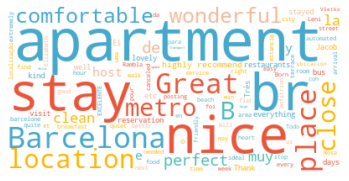

In [50]:
# Get the top 10 and bottom 10 listings based on 'review_scores_rating'
top_10 = df3.nlargest(10, 'review_scores_rating')
bottom_10 = df3.nsmallest(10, 'review_scores_rating')

# Define the custom color palette
colors = np.array(['#FFB600', '#44A9CC', '#EB563A', '#F4B998', '#50BCB9'])

# Create the word cloud for the top 10 listings
top_comments = " ".join(review for review in top_10.comments)
wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue', color_func=lambda *args, **kwargs: colors[np.random.choice(len(colors))])
wordcloud.generate(top_comments)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


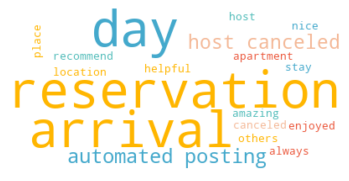

In [51]:
# Create the word cloud for the bottom 10 listings
bottom_comments = " ".join(review for review in bottom_10.comments)
wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue', color_func=lambda *args, **kwargs: colors[np.random.choice(len(colors))])
wordcloud.generate(bottom_comments)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
max_idx_price = df3_pivot['price average'].idxmax()
max_ngbhd = df3_pivot.at[max_idx_price, 'neighbourhood']
max_avg_price = df3_pivot.at[max_idx_price, 'price average']

print(max_ngbhd, ":", max_avg_price)

In [ ]:
min_idx_price = df3_pivot['price average'].idxmin()
min_ngbhd = df3_pivot.at[min_idx_price, 'neighbourhood']
min_avg_price = df3_pivot.at[min_idx_price, 'price average']

print(min_ngbhd, ":", min_avg_price)

In [ ]:
# Add the link containing the geojson file

BCNGeo = 'https://raw.githubusercontent.com/martgnz/bcn-geodata/master/districtes/districtes.geojson'

# Call folium's library to build a new map

BCN_map = folium.Map(location=[41.39, 2.17], zoom_start=12) # in location I must add the city's coordinates

# Build the choropleth map by calling the .choropleth method

BCN_map.choropleth(geo_data=BCNGeo, # GeoJson Coordinates
                   data=df3_distribution,   # The table which contains the data being analized
                   columns=['district', 'accommodations'], # the columns with district denomination and sum of accommodations
                   key_on='feature.properties.NOM', # Chose the key needed in the GeoJson file
                   fill_color='YlOrRd',
                   fill_opacity=0.5,
                   line_opacity=0.4,
                   legend_name='Total Airbnb in BCN 2022') # Title for the map references


BCN_map

In [ ]:
fig4 = px.bar(df3_distribution, x='accommodations', y='district',
            hover_data=['district', 'accommodations'], color='accommodations', 
            color_continuous_scale=['#FDEB6C', '#FC9885', '#FA6821', '#D94C2A', '#E75554', '#74211C'],
            title='Airbnb total distribution in Barcelona', height=600)

fig4.update_layout(plot_bgcolor='#e6e1cf', xaxis_title='Accomodation', yaxis_title='Districts in Barcelona',
xaxis_tickfont=dict(color='#894329'), yaxis_tickfont=dict(color='#894329'), title_font=dict(color='#894329'),
legend=dict(title_font=dict(color='#894329')))


fig4.show()

In [ ]:
fig3 = px.scatter(df3_pivot2, y="price average", x="total locations",
	         size="total beds", color="neighbourhood",
                 hover_name="neighbourhood", height=650, size_max=80)

fig3.update_layout(
    title='Airbnb Barcelona: Total Accomodations, Total Beds, Average Price. By Neighbourhood',
    xaxis=dict(title='Total Available Locations',
        gridcolor='white',
        gridwidth=1,
    ),
    yaxis=dict(
        title='Average Price',
        gridcolor='white',
        gridwidth=1,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)


fig3.show()